In [14]:
# 1 번 셀 --------------------------------
# import copy
# import shutil
# import glob
# import numpy as np
# from torchvision.transforms import ToTensor
# import torchvision.models as models
import pandas as pd
import time
import torch
import torchvision
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
from torch.autograd import Variable
import torch.optim as optim
import torch.nn.functional as F
import torch.nn as nn
import os
import cv2
from PIL import Image
from tqdm.notebook import tqdm_notebook
from tqdm import tqdm
import random
import matplotlib.pyplot as plt
from torchsummary import summary

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
# 2 번 셀 --------------------------------
class ImageTransform:
    def __init__(self, resize, mean, std):
        self.data_transform = {
            "train": transforms.Compose(
                [
                    transforms.RandomResizedCrop(resize, scale=(0.5, 1.0)),
                    transforms.RandomHorizontalFlip(),
                    transforms.ToTensor(),
                    transforms.Normalize(mean, std),
                ]
            ),
            "val": transforms.Compose(
                [
                    transforms.Resize(256),
                    transforms.CenterCrop(resize),
                    transforms.ToTensor(),
                    transforms.Normalize(mean, std),
                ]
            ),
        }
    
    def __call__(self, img, phase):
        return self.data_transform[phase](img)


In [3]:
# 3 번 셀 --------------------------------
cat_directory = r"C:\chungnam_chatbot\pytorch\data\dogs-vs-cats\Cat"
dog_directory = r"C:\chungnam_chatbot\pytorch\data\dogs-vs-cats\Dog"

cat_images_filepaths = sorted([os.path.join(cat_directory, f) for f in os.listdir(cat_directory)])
dog_images_filepaths = sorted([os.path.join(dog_directory, f) for f in os.listdir(dog_directory)])

# [[], []] -> [....]
# cat_images_filepaths.extend(dog_images_filepaths)
images_filepaths = [*cat_images_filepaths, *dog_images_filepaths]

# 에러 처리.
correct_images_filepaths = [i for i in images_filepaths if cv2.imread(i) is not None]

random.seed(42)
random.shuffle(correct_images_filepaths)
train_image_filepaths = correct_images_filepaths[:400]
val_image_filepaths = correct_images_filepaths[400:-10]
test_image_filepaths = correct_images_filepaths[-10:]
print(len(train_image_filepaths), len(val_image_filepaths), len(test_image_filepaths))

400 92 10


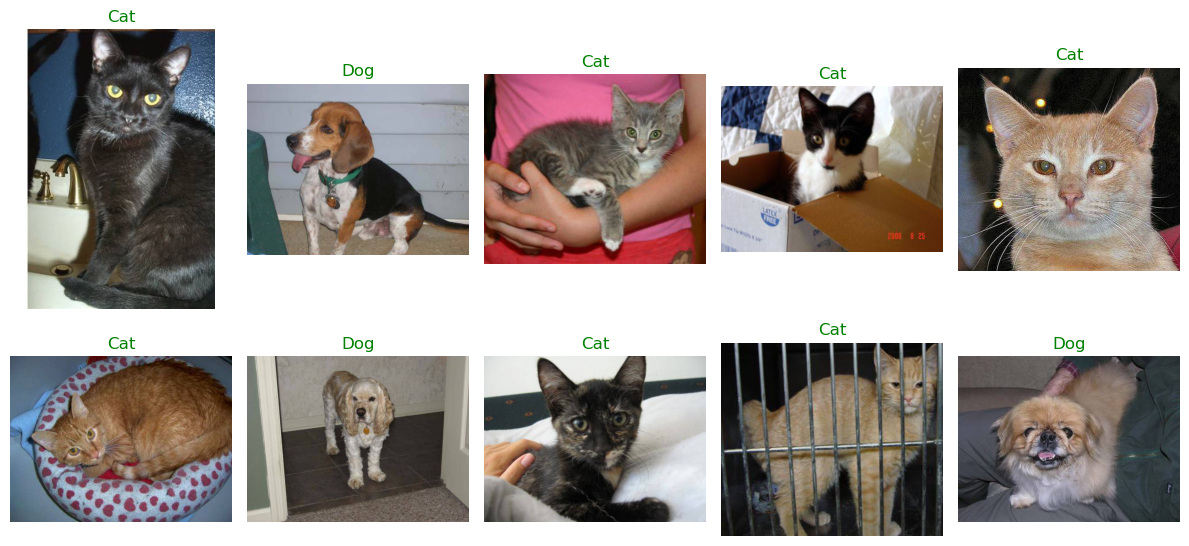

In [4]:
# 4 번 셀 --------------------------------
def display_image_grid(images_filepaths, predicted_labels=(), cols=5):
    rows = len(images_filepaths) // cols
    figure, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(12, 6))
    for i, image_filepath in enumerate(images_filepaths):
        image = cv2.imread(image_filepath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        true_label = os.path.normpath(image_filepath).split(os.sep)[-2]
        predicted_label = predicted_labels[i] if predicted_labels else true_label
        color = "green" if true_label == predicted_label else "red"
        ax.ravel()[i].imshow(image)
        ax.ravel()[i].set_title(predicted_label, color=color)
        ax.ravel()[i].set_axis_off()
    plt.tight_layout()
    plt.show()
    
display_image_grid(test_image_filepaths)

In [5]:
# 5 번 셀 --------------------------------
class DogvsCatDataset(Dataset):
    def __init__(self, file_list, tranform=None, phase="train") -> None:
        super().__init__()
        self.file_list = file_list
        self.transform = tranform
        self.phase = phase

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        img_path = self.file_list[idx]
        img = Image.open(img_path)
        img_transformed = self.transform(img, self.phase)
        label = img_path.split("\\")[-1].split(".")[0]
        if label == "dog":
            label = 1
        elif label == "cat":
            label = 0
        return img_transformed, label

In [6]:
# 6 번 셀 --------------------------------
size = 224
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)
batch_size = 32

train_dataset = DogvsCatDataset(
    train_image_filepaths, tranform = ImageTransform(size, mean, std), phase="train"
)

val_dataset = DogvsCatDataset(
    val_image_filepaths, tranform = ImageTransform(size, mean, std), phase="val"
)
index = 0
# print(train_dataset.__getitem__(index)[0].size())
# print(train_dataset.__getitem__(index)[1])
print(train_dataset[index][0].size())
print(train_dataset[index][1])

torch.Size([3, 224, 224])
0


In [7]:
# 7 번 셀 --------------------------------
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
dataloader_dict = {'train': train_dataloader, 'val': val_dataloader}

batch_iterator = iter(train_dataloader)
inputs, label = next(batch_iterator)
print(inputs.size())
print(label)

torch.Size([32, 3, 224, 224])
tensor([1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1,
        0, 1, 1, 0, 1, 0, 0, 1])


In [8]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.cnn1 = nn.Conv2d(
            in_channels=3, out_channels=16, kernel_size=5, stride=1, padding=0
        )
        self.relu1 = nn.ReLU()
        self.maxpool1 = nn.MaxPool2d(kernel_size=2)
        self.cnn2 = nn.Conv2d(
            in_channels=16, out_channels=32, kernel_size=5, stride=1, padding=0
        )
        self.relu2 = nn.ReLU()  # activation
        self.maxpool2 = nn.MaxPool2d(kernel_size=2)
        self.fc1 = nn.Linear(89888, 512)  # 32*53*53
        self.relu5 = nn.ReLU()
        self.fc2 = nn.Linear(512, 2)
        self.output = nn.Softmax(dim=1)

    def forward(self, x):
        out = self.cnn1(x)
        out = self.relu1(out)
        out = self.maxpool1(out)
        out = self.cnn2(out)
        out = self.relu2(out)
        out = self.maxpool2(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = self.fc2(out)
        out = self.output(out)
        return out

In [9]:
model = LeNet()
model.to(device)
print(model)

LeNet(
  (cnn1): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1))
  (relu1): ReLU()
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (cnn2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
  (relu2): ReLU()
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=89888, out_features=512, bias=True)
  (relu5): ReLU()
  (fc2): Linear(in_features=512, out_features=2, bias=True)
  (output): Softmax(dim=1)
)


In [10]:
from torchsummary import summary

# mat 갯수가 달라지는 애러 발생.
# summary(model, input_size=(3, 244, 244))

In [11]:
# 11 번 셀 --------------------------------
def count_parameter(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameter(model):,} trainable parameters')

The model has 46,038,242 trainable parameters


In [12]:
# 12 번 셀 ---------------------------------
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
criterion = nn.CrossEntropyLoss()

model.to(device)
criterion = criterion.to(device)


def train_model(model, dataloader_dict, criterion, optimizer, num_epoch):
    since = time.time()
    best_acc = 0.0

    for epoch in range(num_epoch):
        print(f"Epoch {epoch+1} / {num_epoch}")
        print("-" * 20)

        for phase in ["train", "val"]:
            if phase == "train":
                model.train()
            else:
                model.eval()

            epoch_loss = 0.0
            epoch_corrects = 0
            for inputs, labels in tqdm_notebook(dataloader_dict[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == "train"):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == "train":
                        loss.backward()
                        optimizer.step()

                    epoch_loss += loss.item() * inputs.size(0)
                    epoch_corrects += torch.sum(preds == labels.data)

            epoch_loss = epoch_loss / len(dataloader_dict[phase].dataset)
            epoch_acc = epoch_corrects.double() / len(dataloader_dict[phase].dataset)

            print(f"{phase} Loss: {epoch_loss} Acc: {epoch_acc}")

            if phase == "val" and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = model.state_dict()

    time_elapsed = time.time() - since
    print(f"Training complete in {time_elapsed//60:.0f}m {time_elapsed % 60:.0f}s")
    return model


num_epoch = 10
model = train_model(model, dataloader_dict, criterion, optimizer, num_epoch)


Epoch 1 / 10
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6982003617286682 Acc: 0.4675


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6982783053232275 Acc: 0.4782608695652174
Epoch 2 / 10
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6851600313186645 Acc: 0.56


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6986827565276105 Acc: 0.5652173913043478
Epoch 3 / 10
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6800576877593995 Acc: 0.58


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.7135888597239619 Acc: 0.5108695652173912
Epoch 4 / 10
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6778833484649658 Acc: 0.5700000000000001


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.7058156806489696 Acc: 0.5217391304347826
Epoch 5 / 10
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6641588687896729 Acc: 0.6125


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6964553931485051 Acc: 0.5869565217391304
Epoch 6 / 10
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6657789063453674 Acc: 0.605


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6886599659919739 Acc: 0.532608695652174
Epoch 7 / 10
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6513745975494385 Acc: 0.6375000000000001


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6814413018848585 Acc: 0.5652173913043478
Epoch 8 / 10
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6423966217041016 Acc: 0.6625


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6868243476618892 Acc: 0.5434782608695652
Epoch 9 / 10
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6469867515563965 Acc: 0.6325000000000001


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6794483635736548 Acc: 0.5869565217391304
Epoch 10 / 10
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.649536201953888 Acc: 0.625


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6879800454429958 Acc: 0.5652173913043478
Training complete in 0m 29s


In [16]:
# 13 번 셀 ---------------------------------
id_list = []
pred_list = []
_id = 0

with torch.no_grad():
    for test_path in tqdm(test_image_filepaths):
        img = Image.open(test_path)
        _id = test_path.split("\\")[-1].split(".")[1]
        transform = ImageTransform(size, mean, std)
        img = transform(img, phase="val")
        img = img.unsqueeze(0)
        img = img.to(device)

        model.eval()
        outputs = model(img)
        preds = F.softmax(outputs, dim=1)[:, 1].tolist()
        id_list.append(_id)
        pred_list.append(preds[0])

res = pd.DataFrame({"id": id_list, "label": pred_list})

res.sort_values(by="id", inplace=True)
res.reset_index(drop=True, inplace=True)

# res.to_csv(r'C:\chungnam_chatbot\pytorch\data', index=False)

res.head()

100%|██████████| 10/10 [00:00<00:00, 37.90it/s]


,id,label
0,109,0.478590
1,145,0.455474
2,15,0.605720
3,162,0.501307
4,167,0.555804


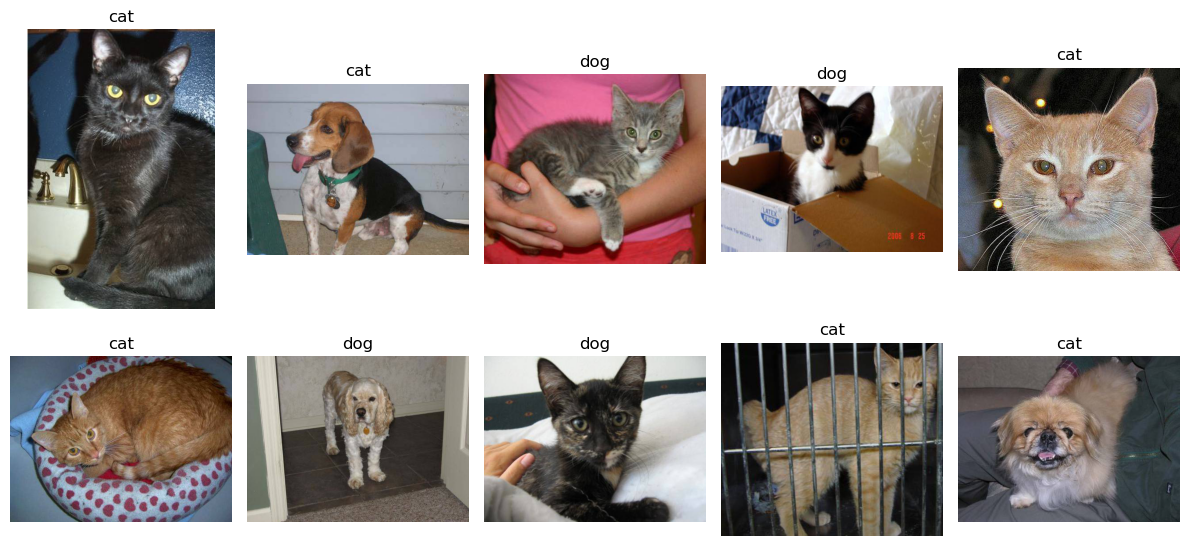

In [17]:
# 14 번 셀 ---------------------------------
class_ = Classes = {0:'cat', 1:'dog'}
def display_image_grid2(images_filepaths, predicted_labels=(), cols=5):
    rows = len(images_filepaths) // cols
    figure, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(12, 6))
    for i, image_filepath in enumerate(images_filepaths):
        image = cv2.imread(image_filepath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        # true_label = os.path.normpath(image_filepath).split(os.sep)[-2]
        # predicted_label = predicted_labels[i] if predicted_labels else true_label
        # color = "green" if true_label == predicted_label else "red"
        a = random.choice(res['id'].values)
        label = res.loc[res['id'] == a, 'label'].values[0]
        if label > 0.5:
            label = 1
        else:
            label = 0
        ax.ravel()[i].imshow(image)
        ax.ravel()[i].set_title(class_[label])
        ax.ravel()[i].set_axis_off()
    plt.tight_layout()
    plt.show()
    
display_image_grid2(test_image_filepaths)